# Dimensionality Reduction

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style="whitegrid")
sns.set_color_codes()

from collections import defaultdict

In [2]:
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

######## Evaluation #######
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, plot_precision_recall_curve

from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

In [3]:
from pyod.models.abod import ABOD
from sklearn.ensemble import IsolationForest
import eif as iso
from sklearn.neighbors import LocalOutlierFactor

In [4]:
from sklearn.metrics.pairwise import euclidean_distances

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

from collections import Counter
from collections import defaultdict

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

---
## Data Preparation

In [5]:
df_train = pd.read_csv('csv/train.csv')
df_test = pd.read_csv('csv/test.csv')

In [6]:
# Define the Target attribute "Class" - Walk upstairs

df_train['Class'] = 0
df_test['Class'] = 0

df_train.loc[(df_train['Activity']==2), 'Class'] = 1
df_test.loc[(df_test['Activity']==2), 'Class'] = 1

In [7]:
to_drop = ['ActivityName','subject',"Activity"]    

X_train = df_train.drop(to_drop, axis=1, inplace=False)

X_test = df_test.drop(to_drop, axis=1, inplace=False)

In [8]:
attributes = [col for col in X_train.columns if col != 'Class']

X = X_train[attributes].values
y = X_train['Class']

X_t = X_test[attributes].values
y_t = X_test['Class']

---
## PCA - Principal Component Analysis

In [32]:
from sklearn.decomposition import PCA

In [33]:
pca = PCA(n_components=2)
pca.fit(X)
X_train_pca = pca.transform(X)

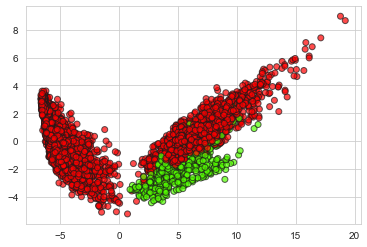

In [35]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

---
## IsoMap

In [9]:
from sklearn.manifold import Isomap 

In [12]:
iso_map = Isomap(n_neighbors=10, n_components=2)
X_train_rsp = iso_map.fit_transform(X)
X_train_rsp.shape

(7352, 2)

In [38]:
X_test_rsp = iso_map.fit_transform(X_t)
X_test_rsp.shape

(2947, 2)

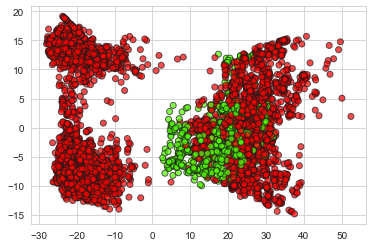

In [15]:
plt.scatter(X_train_rsp[:, 0], X_train_rsp[:, 1], c=y, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

---
# Outlier Detection

Outlier detection on the reduced dataset

---
## Isolation Forest

In [16]:
# standard eif
F0  = iso.iForest(X_train_rsp,ntrees=500, sample_size=256, ExtensionLevel=0) 

# extended eif
F1  = iso.iForest(X_train_rsp,ntrees=500, sample_size=256, ExtensionLevel=1)  

In [17]:
# Score the training data itself to see the distribution of the anomaly scores each point receives. 

S0 = F0.compute_paths(X_in=X_train.values)

S1 = F1.compute_paths(X_in=X_train.values)

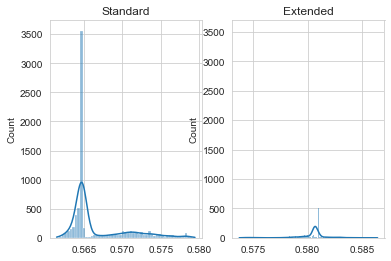

In [18]:
fig , axes = plt.subplots(1 , 2)

sns.histplot(S0,ax=axes[0] ,  kde = True )
axes[0].set_title("Standard")

sns.histplot(S1,ax=axes[1] ,  kde = True )
axes[1].set_title('Extended')

plt.show()

In [29]:
xx, yy = np.meshgrid(np.linspace(-60, 60, 300), np.linspace(-60, 60, 200))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)

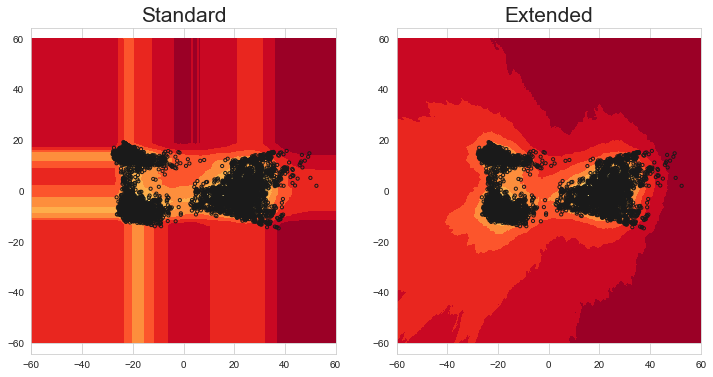

In [30]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
plt.scatter(X_train_rsp[:, 0], X_train_rsp[:, 1],s=10,c='None',edgecolor='k')
plt.axis("equal")
ax1.set_title("Standard",fontsize=21,y=1)


ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S1),10)
CS = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
plt.scatter(X_train_rsp[:, 0], X_train_rsp[:, 1],s=10,c='None',edgecolor='k')
plt.axis("equal")
ax2.set_title("Extended",fontsize=21,y=1)

#f.suptitle('Score maps Isolation Forest',fontsize=24, y=1.03)
plt.show()

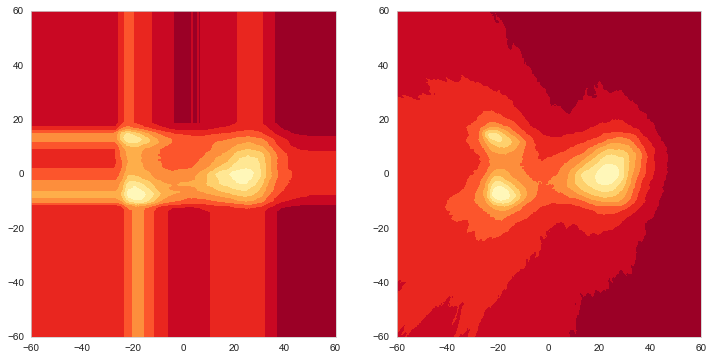

In [31]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)

ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S1),10)
CS = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)


plt.show()

---
# Classification & Imbalanced Learning

Classification on the reduced dataset

---
## KNN

Accuracy 0.8242280285035629
F1-score [0.89467263 0.4692623 ]
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2476
           1       0.45      0.49      0.47       471

    accuracy                           0.82      2947
   macro avg       0.68      0.69      0.68      2947
weighted avg       0.83      0.82      0.83      2947



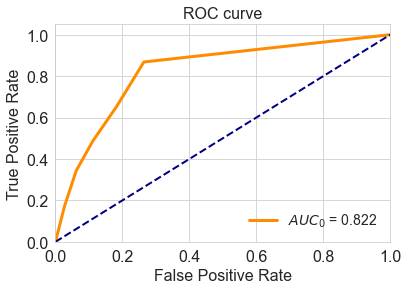

In [58]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train_rsp,y)

y_pred = clf.predict(X_test_rsp)

print('Accuracy %s' % accuracy_score(y_t, y_pred))
print('F1-score %s' % f1_score(y_t, y_pred, average=None))
print(classification_report(y_t, y_pred))

y_score = clf.predict_proba(X_test_rsp)
fpr_0, tpr_0, _ = roc_curve(y_t, y_score[:, 1])
roc_auc_0 = auc(fpr_0, tpr_0)

plt.plot(fpr_0, tpr_0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc_0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [68]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train_rsp, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1073, 1: 1073})


In [69]:
### KNN

clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_res,y_res)

y_pred = clf.predict(X_test_rsp)

print('Accuracy %s' % accuracy_score(y_t, y_pred))
print('F1-score %s' % f1_score(y_t, y_pred, average=None))
print(classification_report(y_t, y_pred))

Accuracy 0.7441465897522904
F1-score [0.82554373 0.52035623]
              precision    recall  f1-score   support

           0       0.97      0.72      0.83      2476
           1       0.37      0.87      0.52       471

    accuracy                           0.74      2947
   macro avg       0.67      0.79      0.67      2947
weighted avg       0.87      0.74      0.78      2947



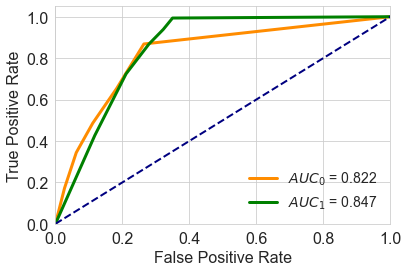

In [70]:
y_score = clf.predict_proba(X_test_rsp)
fpr, tpr, _ = roc_curve(y_t, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr_0, tpr_0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc_0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
#plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [71]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_rsp, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 6279, 1: 6279})


In [72]:
#KNN

clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_res,y_res)

y_pred = clf.predict(X_test_rsp)

print('Accuracy %s' % accuracy_score(y_t, y_pred))
print('F1-score %s' % f1_score(y_t, y_pred, average=None))
print(classification_report(y_t, y_pred))

Accuracy 0.7702748557855447
F1-score [0.85045284 0.50475494]
              precision    recall  f1-score   support

           0       0.94      0.78      0.85      2476
           1       0.39      0.73      0.50       471

    accuracy                           0.77      2947
   macro avg       0.66      0.75      0.68      2947
weighted avg       0.85      0.77      0.80      2947



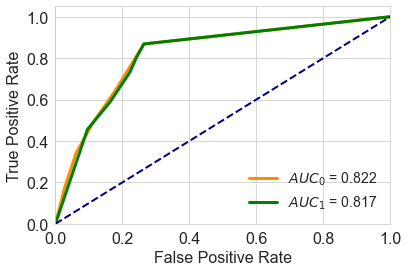

In [73]:
y_score = clf.predict_proba(X_test_rsp)
fpr, tpr, _ = roc_curve(y_t, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr_0, tpr_0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc_0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
#plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [74]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_rsp, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 6279, 1: 6279})


In [75]:
# KNN

clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_res,y_res)

y_pred = clf.predict(X_test_rsp)

print('Accuracy %s' % accuracy_score(y_t, y_pred))
print('F1-score %s' % f1_score(y_t, y_pred, average=None))
print(classification_report(y_t, y_pred))

Accuracy 0.7746861214794707
F1-score [0.85425812 0.50373692]
              precision    recall  f1-score   support

           0       0.94      0.79      0.85      2476
           1       0.39      0.72      0.50       471

    accuracy                           0.77      2947
   macro avg       0.66      0.75      0.68      2947
weighted avg       0.85      0.77      0.80      2947



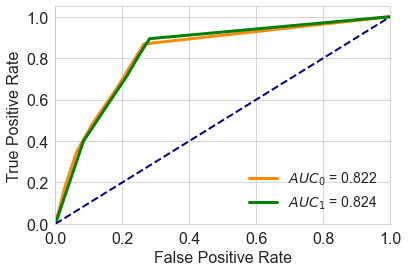

In [76]:
y_score = clf.predict_proba(X_test_rsp)
fpr, tpr, _ = roc_curve(y_t, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr_0, tpr_0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc_0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
#plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()